In [1]:
import sys
sys.path.append('..')
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import get_n_columns
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:
class John_Ehlers():
    def __init__(
        self,
        df,
        strategy_type=["long"],
        #period = 35,
    ):
        self.df = df
        self.use_long = True if "long" in strategy_type else False
        self.use_short = True if "short" in strategy_type else False
        #self.period = 35
        
    def populate_indicators(self, period = 120):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        sqrt_period = np.sqrt(period)

        def John(x, y):
            alpha = 2 / (y + 1)
            sum = np.zeros(len(x))
            sum[0] = alpha * x[0]
            for i in range(1, len(x)):
                sum[i] = alpha * x[i] + (1 - alpha) * sum[i-1]
            return sum

        close_ema1 = John(df['close'], int(period / 2))
        close_ema2 = John(df['close'], period)
        ehma = John(2 * close_ema1 - close_ema2, sqrt_period)

        df['ehma'] = ehma
        df['ehma_1'] = df['ehma'].shift(1)
        df.columns = df.columns.str.lower()

        df = get_n_columns(df, ["ehma", "ehma_1", "close"], 1)
        self.df = df
     #   self.df = df.loc['2021-03-30':]  
        return self.df
    
    def populate_buy_sell(self): 
        #df = self.df
        # -- Initiate populate --
        self.df["open_long_market"] = False
        self.df["close_long_market"] = False
        self.df["open_short_market"] = False
        self.df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            self.df.loc[
                (self.df['ehma'] > self.df['ehma_1']) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            self.df.loc[
                (self.df['ehma'] < self.df['ehma_1']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            self.df.loc[
                (self.df['ehma'] < self.df['ehma_1']) 
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            self.df.loc[
                (self.df['ehma'] > self.df['ehma_1']) 
                , "close_short_market"
            ] = True
        
        #self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1):
        df = self.df
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":   
                    leverage = 2                  
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    leverage = 1
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        result_dict = {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }
        result_dict.update(get_metrics(df_trades, df_days))
        return result_dict
        

In [3]:
import yfinance as yf

btc = yf.Ticker('BTC-USD').history(period="5y", interval='1d')
df = btc.copy()
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-03-31 00:00:00+00:00,28032.261719,28639.896484,27583.714844,28478.484375,19001327598,0.0,0.0
2023-04-01 00:00:00+00:00,28473.332031,28802.457031,28297.171875,28411.035156,10876469901,0.0,0.0
2023-04-02 00:00:00+00:00,28462.845703,28518.958984,27884.087891,28199.308594,12284641999,0.0,0.0
2023-04-03 00:00:00+00:00,28183.080078,28475.623047,27276.720703,27790.220703,19556501327,0.0,0.0
2023-04-04 00:00:00+00:00,27769.535156,28134.226562,27701.496094,27991.767578,19311095808,0.0,0.0


In [4]:
df.reset_index(drop = False, inplace = True)
df.columns = df.columns.str.lower()
#print(df.tail())
df.drop(columns=['dividends','stock splits'], inplace=True)
#df.columns = df.columns.str.capitalize()
df.rename(columns = {'date':'timestamp'},inplace=True)
df.set_index('timestamp', inplace=True)

Period: [2018-04-04 00:00:00] -> [2023-04-04 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 40890.69 $
Performance vs US dollar: 3989.07 %
Sharpe Ratio: 1.3
Worst Drawdown T|D: -77.6% | -79.64%
Buy and hold performance: 308.41 %
Performance vs buy and hold: 901.22 %
Total trades on the period: 54
Global Win rate: 38.89 %
Average Profit: 16.62 %
Total fees paid 2094.71$

Best trades: +372.64 % the 2020-10-10 00:00:00+00:00 -> 2021-01-25 00:00:00+00:00
Worst trades: -42.06 % the 2022-10-25 00:00:00+00:00 -> 2022-11-09 00:00:00+00:00


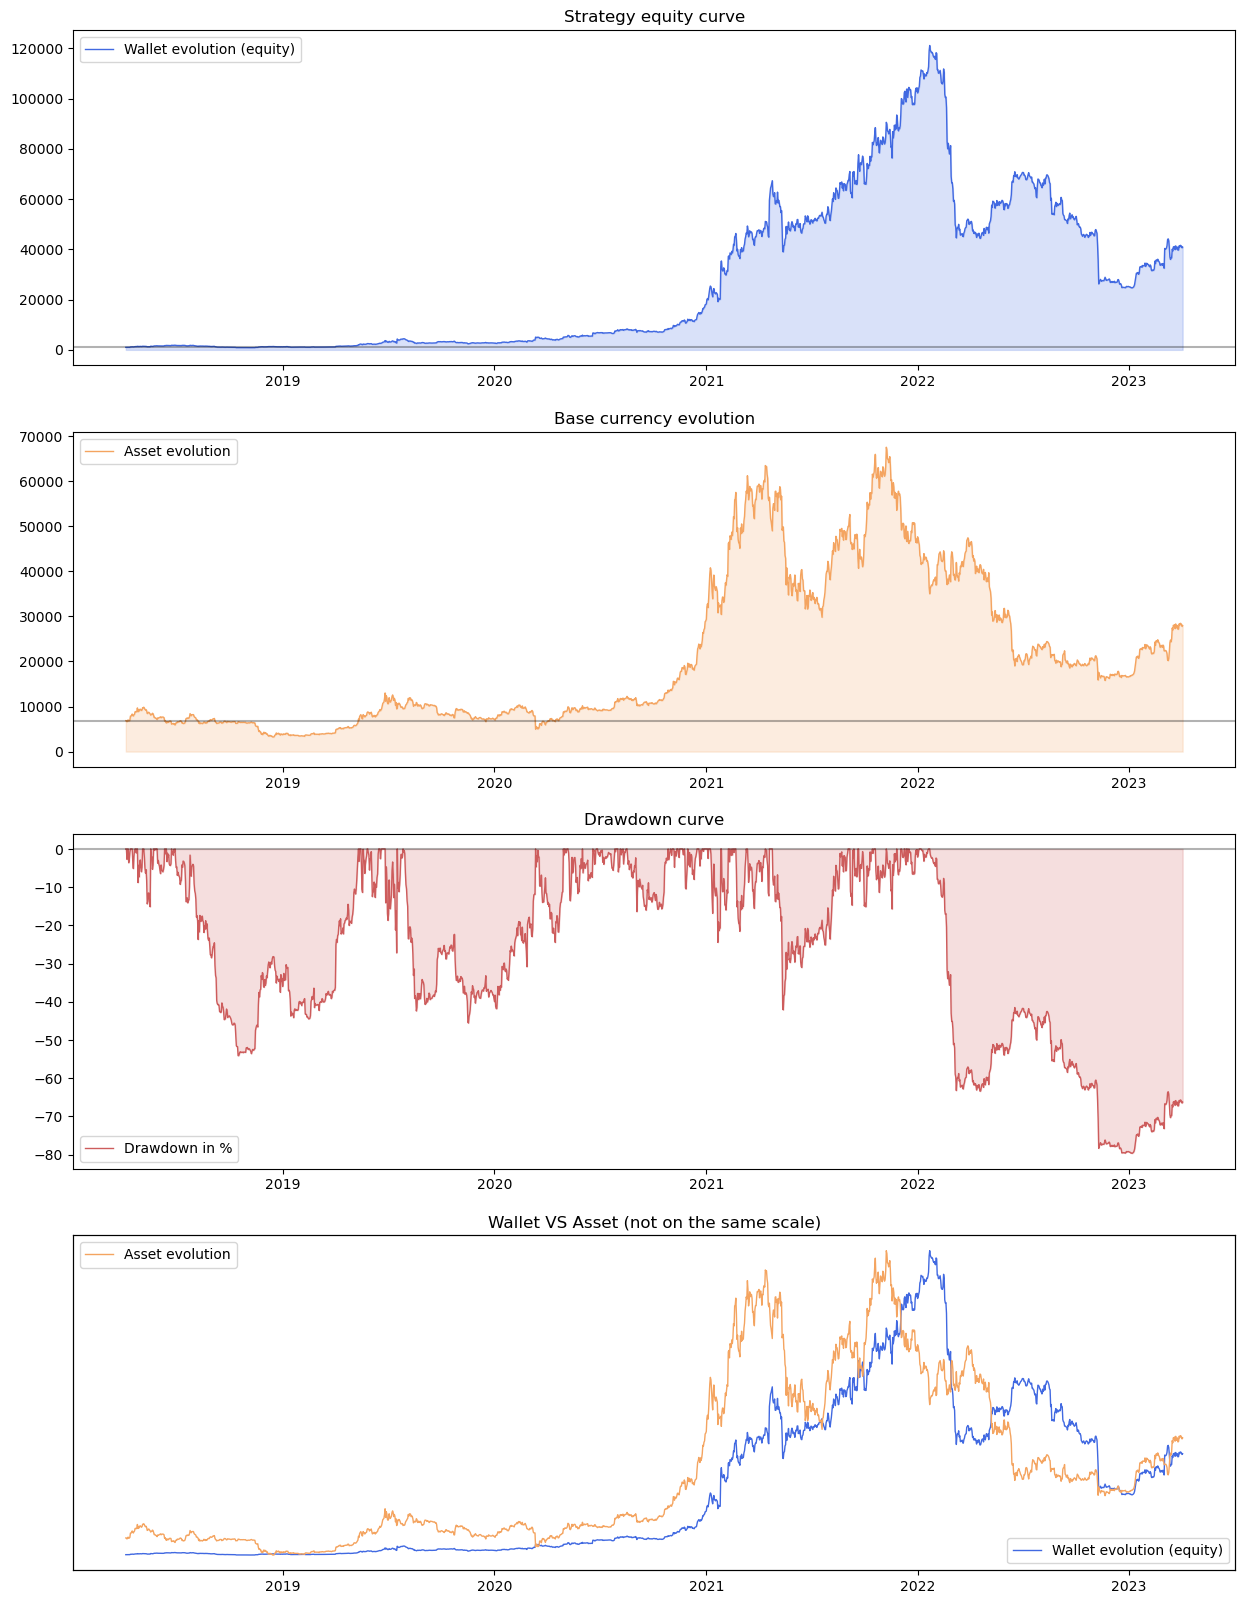

In [5]:
strat = John_Ehlers(
    df = df.copy(),
    strategy_type=["long","short"],
)


strat.populate_indicators(period = 63)
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=2)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)


In [7]:
df_trades.to_csv('trades_63.csv')

----- 2018 Cumulative Performances: 23.57% -----


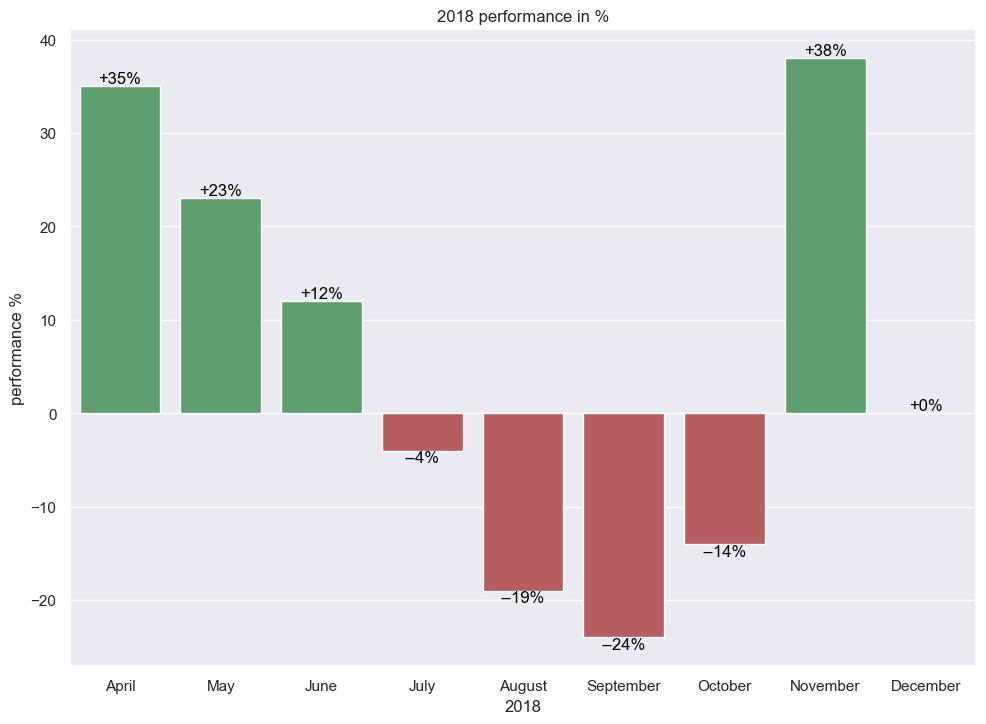

----- 2019 Cumulative Performances: 121.61% -----


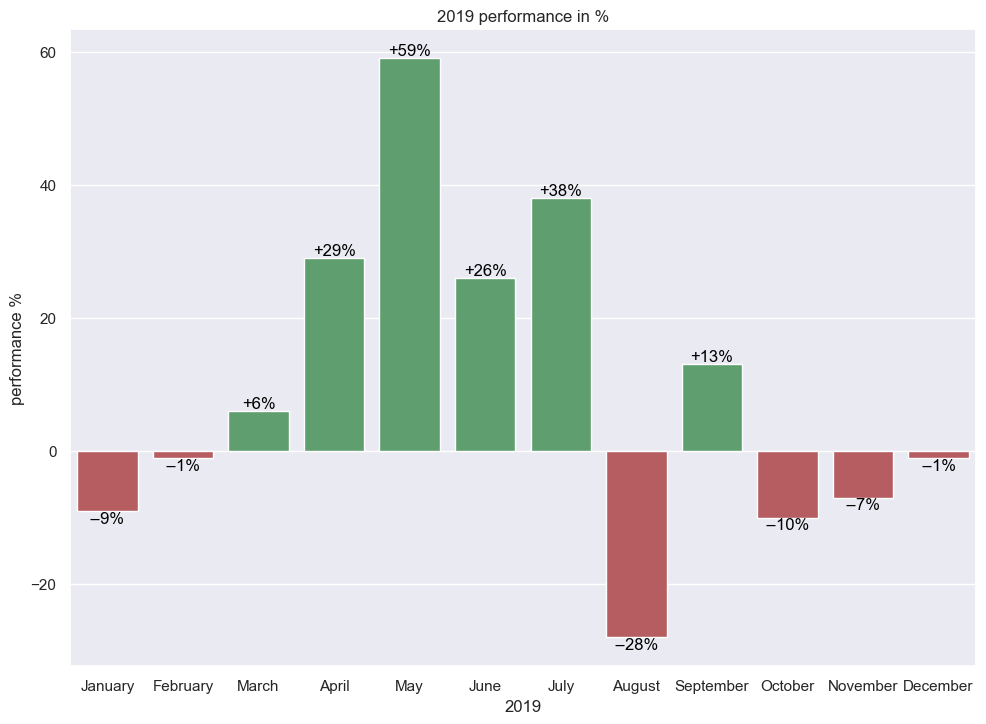

----- 2020 Cumulative Performances: 580.33% -----


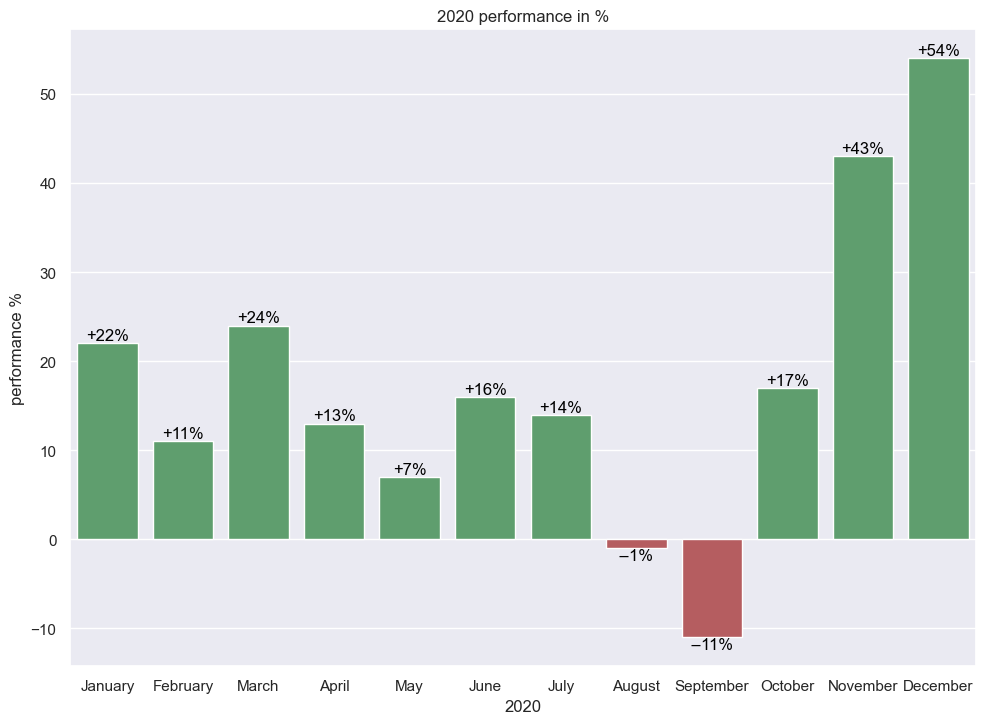

----- 2021 Cumulative Performances: 470.74% -----


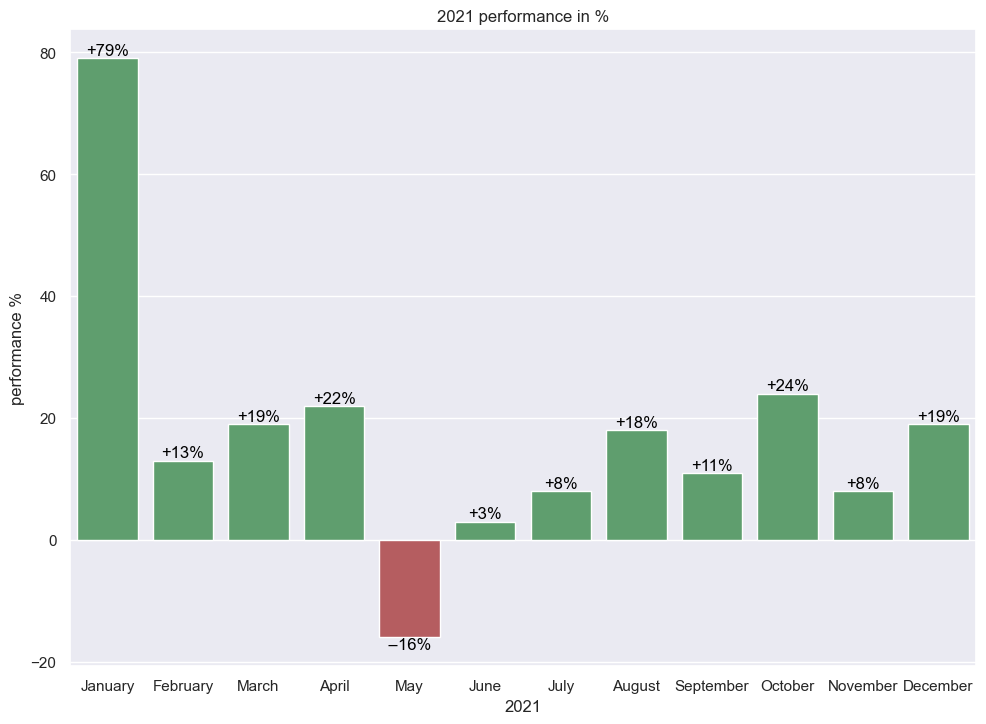

----- 2022 Cumulative Performances: -75.3% -----


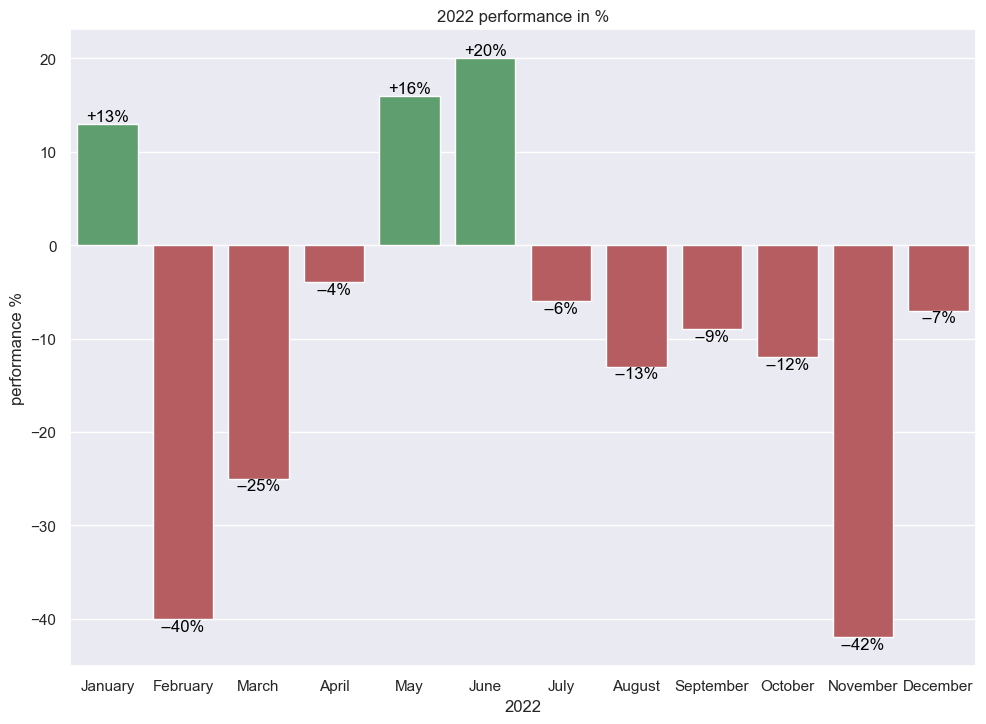

----- 2023 Cumulative Performances: 62.84% -----


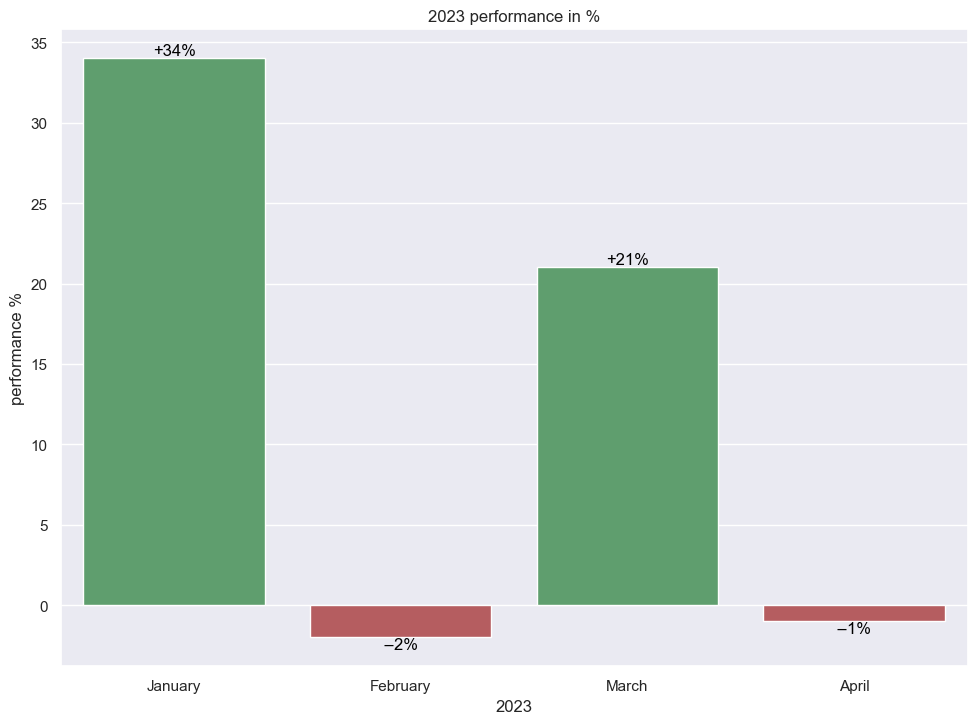

In [ ]:
plot_bar_by_month(df_days=df_days)

Period: [2018-04-03 00:00:00] -> [2023-04-03 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 42053.08 $
Performance vs US dollar: 4105.31 %
Sharpe Ratio: 1.31
Worst Drawdown T|D: -45.82% | -70.68%
Buy and hold performance: 275.98 %
Performance vs buy and hold: 1018.49 %
Total trades on the period: 25
Global Win rate: 52.0 %
Average Profit: 40.58 %
Total fees paid 683.41$

Best trades: +660.32 % the 2020-10-11 00:00:00+00:00 -> 2021-04-25 00:00:00+00:00
Worst trades: -36.56 % the 2018-07-23 00:00:00+00:00 -> 2018-08-08 00:00:00+00:00


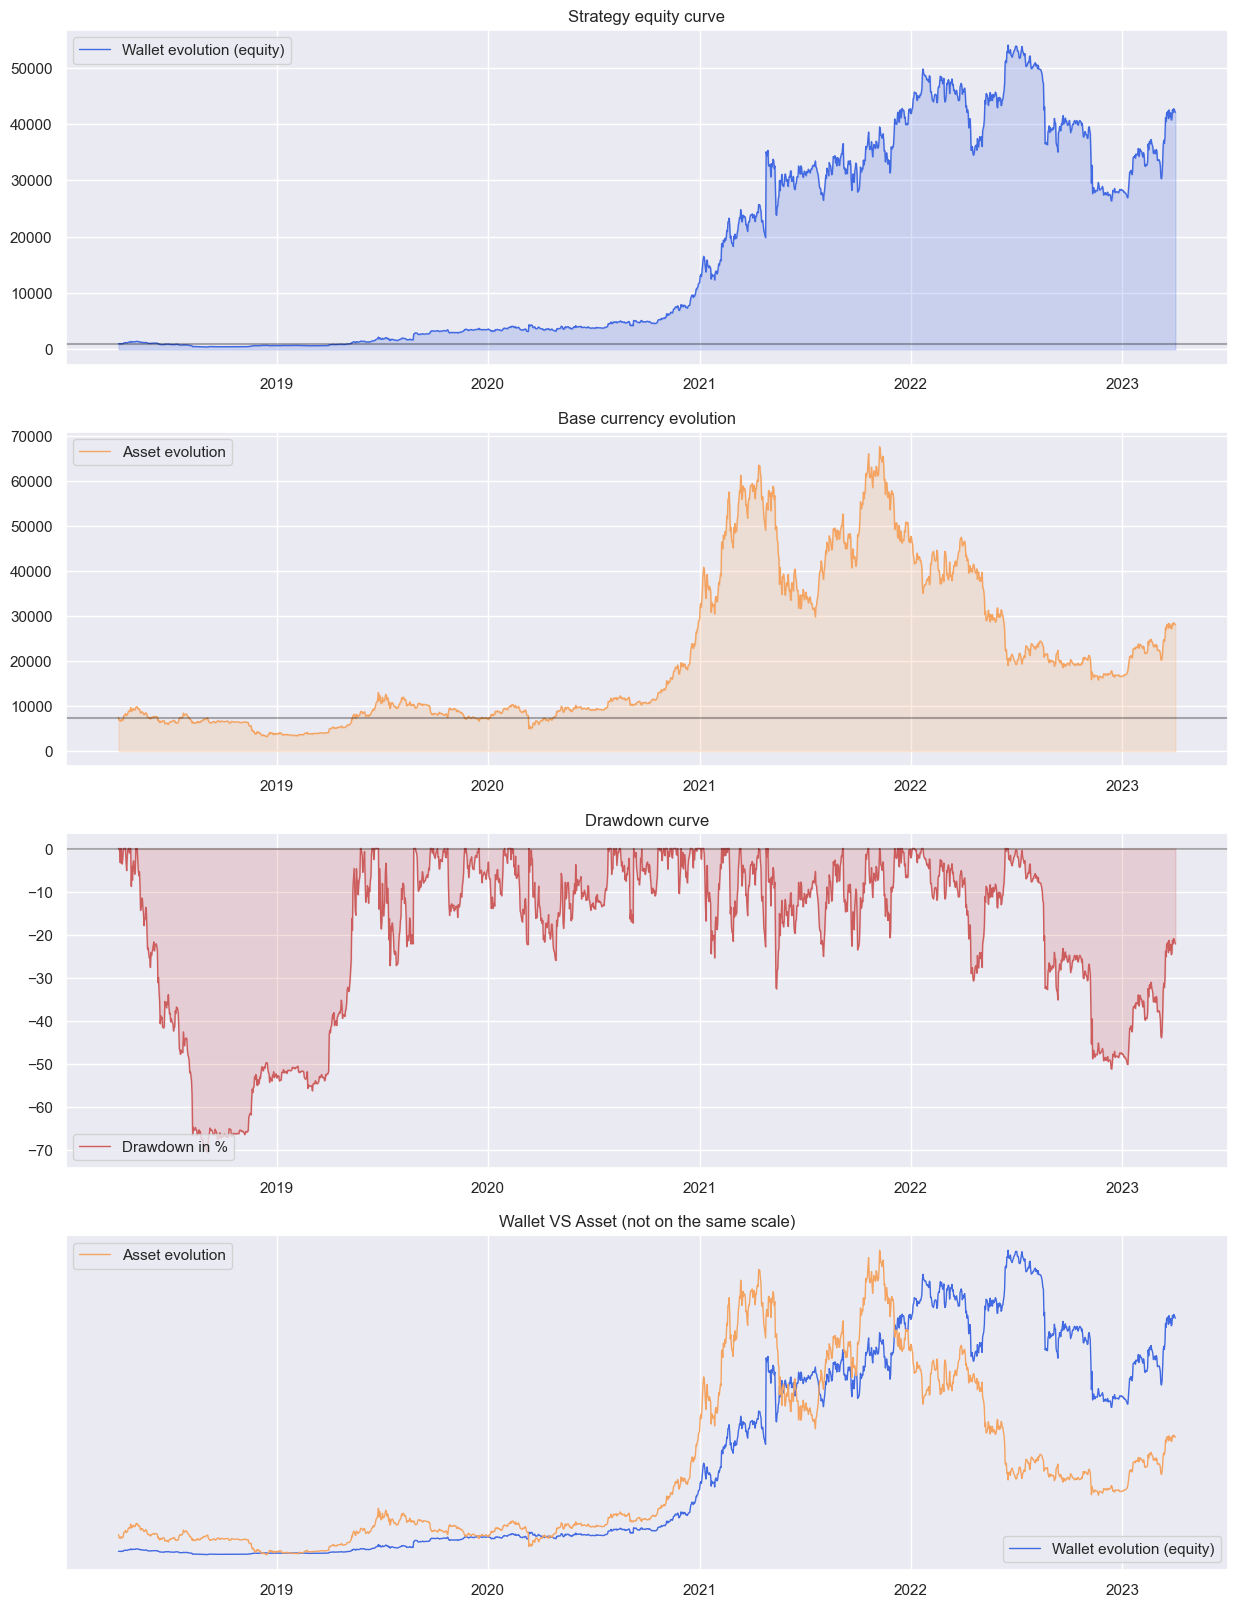

In [ ]:
strat = John_Ehlers(
    df = df.copy(),
    strategy_type=["long","short"],
)


strat.populate_indicators(period = 154)
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

----- 2018 Cumulative Performances: 23.57% -----


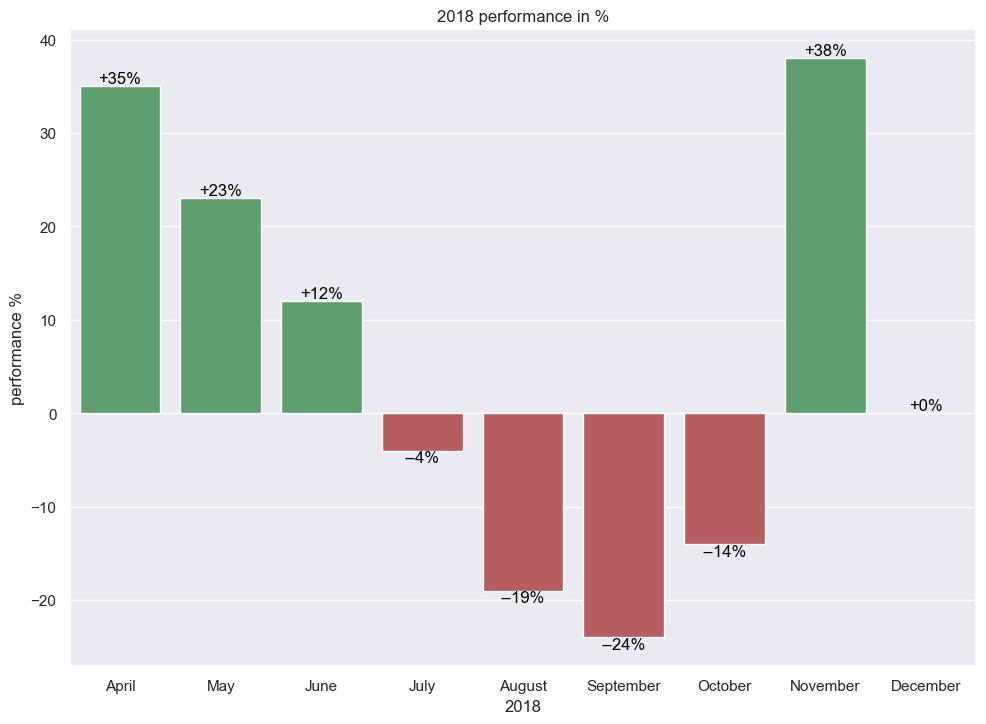

----- 2019 Cumulative Performances: 121.61% -----


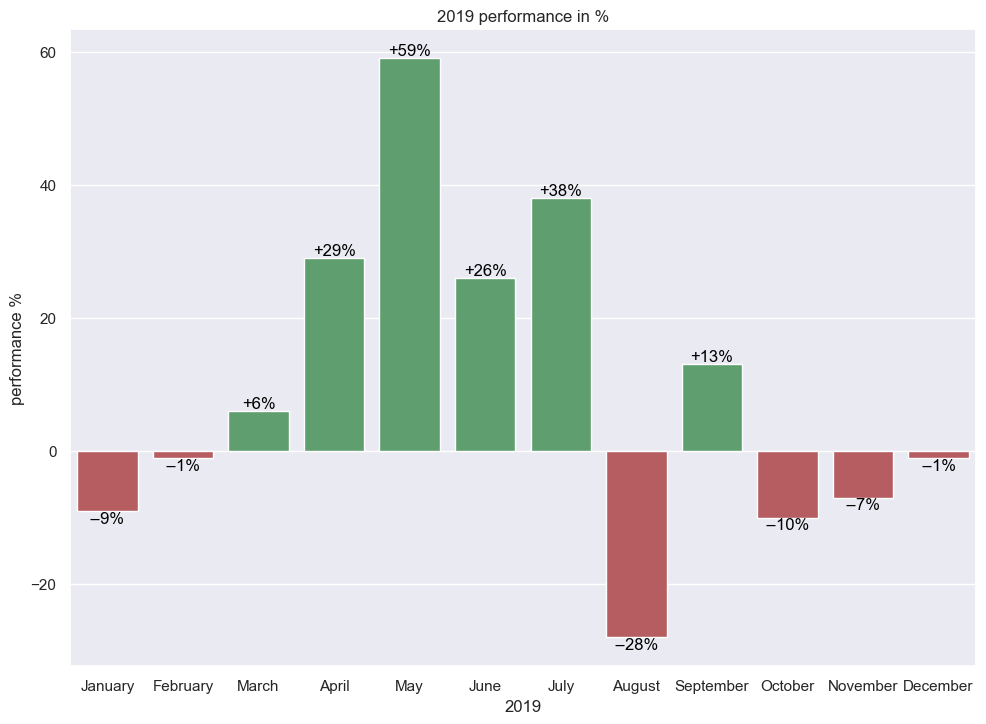

----- 2020 Cumulative Performances: 580.33% -----


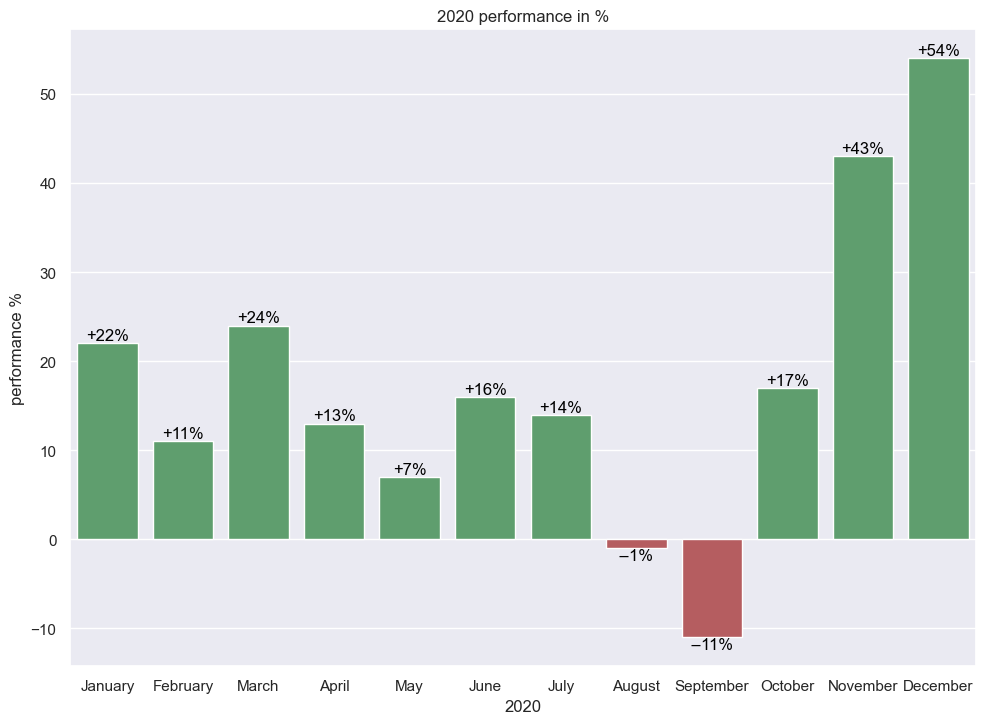

----- 2021 Cumulative Performances: 470.74% -----


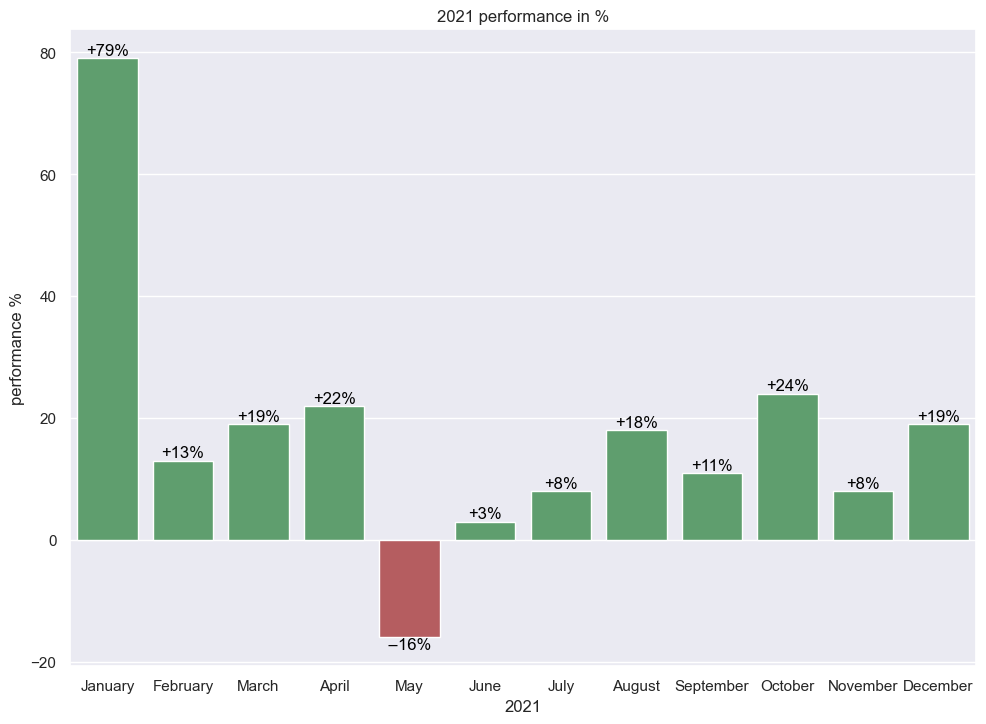

----- 2022 Cumulative Performances: -75.3% -----


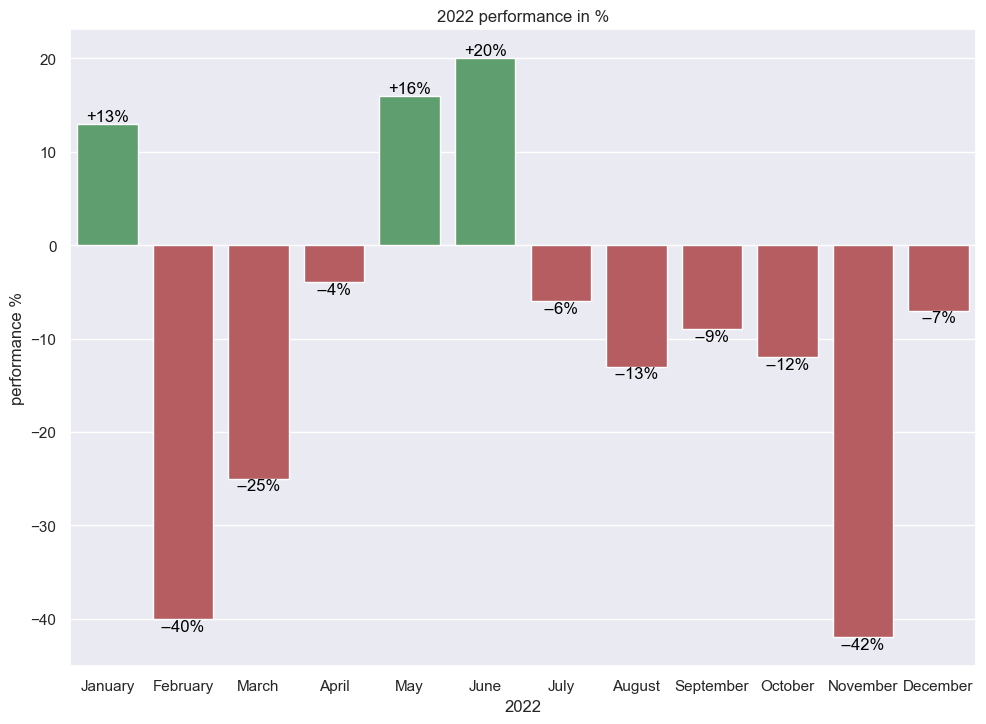

----- 2023 Cumulative Performances: 62.95% -----


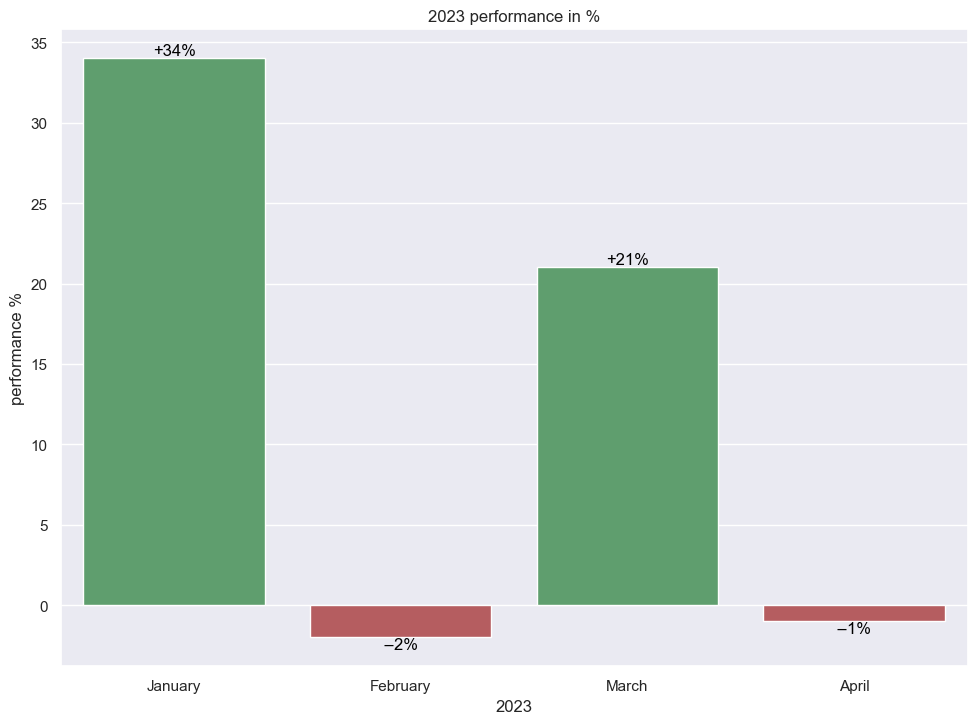

In [7]:
plot_bar_by_month(df_days=df_days)